# Alzheimer's Disease and the Frontal Lobe
### Introduction to Computational Medicine I:  Imaging

Adam Kenet, Chenyu Gao, Zixuan Wang, Shardul Rakshit

October 2020

### Data Cleaning

In [1]:
# import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import stats
from scipy.stats import zscore

# inline plots
%matplotlib inline

In [2]:
# read the ADNI data
dat_all = pd.read_excel('ADNI_ICM_random200.xlsx')
dat_all = dat_all.replace({'\'':''}, regex=True) # remove ' ' from data
dat_all = dat_all.rename(columns=lambda x:x.strip('\'')) # remove ' ' from column names
dat_all.index += 1 # change index to start at 1
dat_all

,Subject_ID,Gender,Age,Diagnosis,ACR_R,AGWM_R,AG_R,ALIC_R,Amyg_R,AnteriorBasalForebrain_R,...,TempSul_L,Thalamus_L,dorsalWM_ACC_L,dorsal_ACC_L,rostralWM_ACC_L,rostral_ACC_L,subcallosalWM_ACC_L,subcallosal_ACC_L,subgenualWM_ACC_L,subgenual_ACC_L
1,Subject_1,M,69.6712,AD/MCI,14005,2932,10758,2073,1725,363,...,1349,5452,1424,10839,12,2082,95,369,226,1828
2,Subject_2,F,85.3836,AD/MCI,8811,2115,9418,2317,1590,276,...,1368,4578,1187,9102,5,1782,38,342,128,1438
3,Subject_3,F,86.2904,NORMAL,11982,2634,11015,2589,1803,299,...,1337,5987,1601,9902,92,1956,39,472,127,1644
4,Subject_4,M,73.9342,NORMAL,11919,3688,11322,2058,1868,217,...,1187,5005,1705,12301,12,1724,97,329,133,1485
5,Subject_5,M,79.9918,AD/MCI,10588,3010,11657,2161,1275,232,...,2131,5239,1517,11344,45,1823,28,312,90,1758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Subject_196,F,81.1425,NORMAL,9143,2421,9444,1854,1437,220,...,1204,4657,1067,8714,0,1572,57,323,158,1467
197,Subject_197,M,85.1589,AD/MCI,10216,2989,11283,2106,1882,271,...,1300,5351,1456,10322,35,1956,48,309,168,1334
198,Subject_198,F,66.9014,AD/MCI,11899,2717,9606,2027,1334,223,...,1383,5392,1536,10953,7,1923,44,279,176,1456
199,Subject_199,F,77.0932,NORMAL,11144,2569,10168,2090,1885,256,...,1372,4877,1562,10345,44,2370,29,372,164,1925


In [3]:
# select only the columns of interest
rois = ['IFG_opercularis_L','IFG_orbitalis_L','IFG_triangularis_L','LFOG_L','MFG_L','MFOG_L','PrCG_L','SFG_L',
       'IFG_opercularis_R','IFG_orbitalis_R','IFG_triangularis_R','LFOG_R','MFG_R','MFOG_R','PrCG_R','SFG_R']
info = ['Subject_ID', 'Gender', 'Age', 'Diagnosis']
columns = np.concatenate((info, rois), axis=0)
dat = dat_all[columns]
#dat

In [4]:
# split into Alzheimer's group and control group
ad = dat[dat.Diagnosis == 'AD/MCI']
control = dat[dat.Diagnosis == 'NORMAL']

In [5]:
#ad

In [6]:
#control.describe()

### Characterization of the ADNI Dataset
- Butterfly plot (age distribution)

In [7]:
#determine the number of people in each age group
bin_max = 93
bin_min = 55
bin_gap = 2
hist_ad_female, bin_edges = np.histogram(ad[ad.Gender == 'F']['Age'],bins=np.arange(bin_min,bin_max,bin_gap))
hist_ad_male, bin_edges = np.histogram(ad[ad.Gender == 'M']['Age'],bins=np.arange(bin_min,bin_max,bin_gap))
hist_control_female, bin_edges = np.histogram(control[control.Gender == 'F']['Age'],bins=np.arange(bin_min,bin_max,bin_gap))
hist_control_male, bin_edges = np.histogram(control[control.Gender == 'M']['Age'],bins=np.arange(bin_min,bin_max,bin_gap))

AgeGroup = [] #create a list of age group, strings
for i in bin_edges:
    if i == bin_max - bin_gap: break
    AgeGroup.append(str(i)+ '-' +str(i+bin_gap))

#create a dataframe for plotting
d_gender_diagnosis = {'AgeGroup':AgeGroup,
     'AD_Female':hist_ad_female,
     'AD_Male':hist_ad_male,
     'Control_Female':hist_control_female * -1,
     'Control_Male':hist_control_male *-1}
df_gender_diagnosis = pd.DataFrame(data=d_gender_diagnosis)
df_gender_diagnosis['AD_Tot'] = df_gender_diagnosis['AD_Male'] + df_gender_diagnosis['AD_Female']
df_gender_diagnosis['Control_Tot'] = df_gender_diagnosis['Control_Male'] + df_gender_diagnosis['Control_Female'] 
#df_gender_diagnosis.info()
df_gender_diagnosis_rev = df_gender_diagnosis[::-1] #for plotting

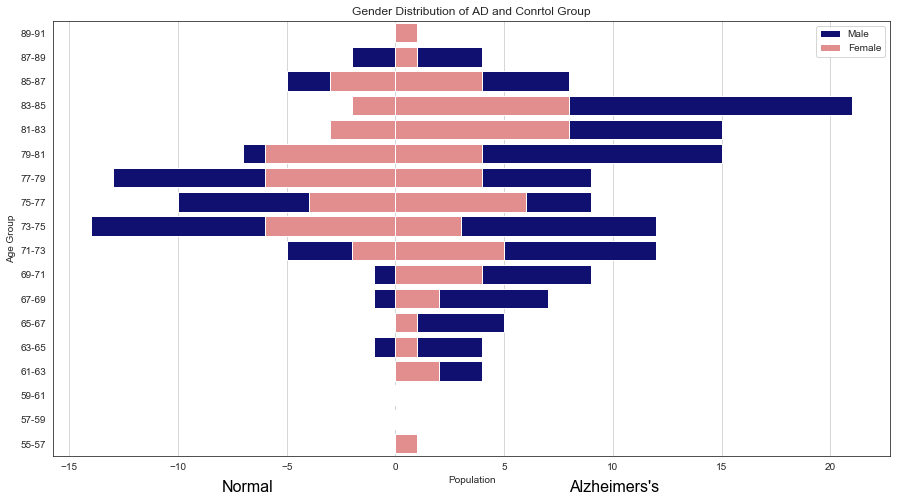

In [8]:
sns.set_style("white")
plt.figure(figsize=(15,8))

bar_plot = sns.barplot(x="AD_Tot",y="AgeGroup", color="navy", label="Male",data = df_gender_diagnosis_rev)
bar_plot = sns.barplot(x="Control_Tot",y="AgeGroup", color="navy", data = df_gender_diagnosis_rev)
bar_plot = sns.barplot(x="AD_Female",y="AgeGroup", color='lightcoral', label="Female",data = df_gender_diagnosis_rev)
bar_plot = sns.barplot(x="Control_Female",y="AgeGroup", color="lightcoral", data = df_gender_diagnosis_rev)

# Labels 
bar_plot.set(xlabel="Population", ylabel="Age Group", title = "Gender Distribution of AD and Conrtol Group");
bar_plot.xaxis.grid(True)
plt.text(-8,19,'Normal',fontdict={'size':'16','color':'black'})
plt.text(8,19,"Alzheimers's",fontdict={'size':'16','color':'black'})
plt.legend();

### Comparison Between Alzheimer's and Control Groups
- Violin plots
- Box plots
- z-score barcodes

In [9]:
# split patient info and volume data
ad_info = ad[info]
ad_volume = ad[rois]
control_info = control[info]
control_volume = control[rois]

In [10]:
#ad_volume

In [11]:
#control_volume

In [12]:
# create new df with mean and standard deviation for both groups
mean_std = pd.DataFrame({'ad_mean':ad_volume.mean(), 'ad_std':ad_volume.std(), 
                         'control_mean':control_volume.mean(), 'control_std':control_volume.std()})
#mean_std

In [13]:
'''#violin plot to show the differences in structure volumes between AD and control group
#contact Chenyu Gao if you find anything wrong in this block

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))

# plot violin plot
for i in range(0,16):
    compare = [ad_volume.iloc[:,i],control_volume.iloc[:,i]] #collect data from AD and control group
    axes[i//4,i%4].violinplot(compare,
                   showmeans=False,
                   showmedians=True) #loop and plot
    axes[i//4,i%4].set_title(control_volume.columns[i])
    axes[i//4,i%4].set_xlabel('Group')
    axes[i//4,i%4].set_ylabel('Structure Volume')
    axes[i//4,i%4].yaxis.grid(True) #add horizontal grid line

# add x-tick labels
plt.setp(axes, xticks=[1,2],
         xticklabels=['AD', 'Control'])

plt.show()''';

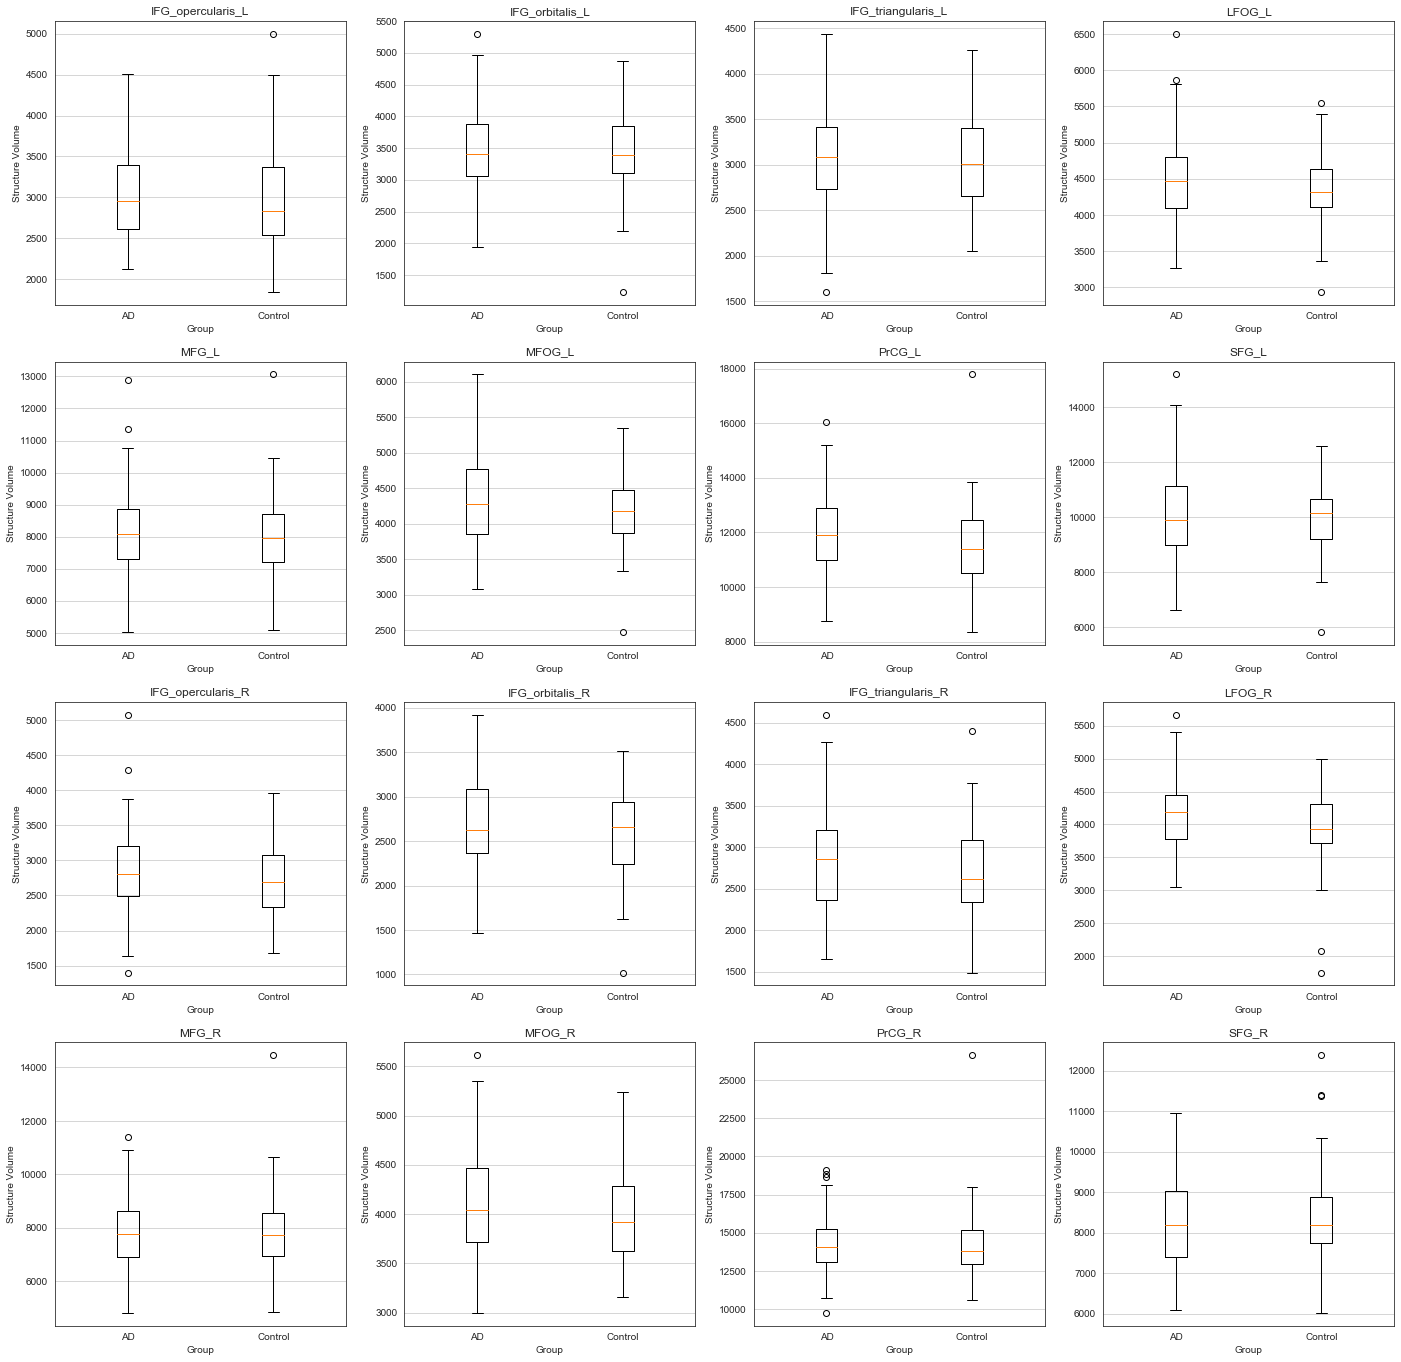

In [14]:
# box plot may look more scientific but contain less information I think
#contact Chenyu Gao if you find anything wrong in this block

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))

#plot box plot
for i in range(0,16):
    compare = [ad_volume.iloc[:,i],control_volume.iloc[:,i]] #collect data from AD and control group
    axes[i//4,i%4].boxplot(compare)#loop and plot
    axes[i//4,i%4].set_title(control_volume.columns[i])
    axes[i//4,i%4].set_xlabel('Group')
    axes[i//4,i%4].set_ylabel('Structure Volume')
    axes[i//4,i%4].yaxis.grid(True) #add horizontal grid line

# add x-tick labels
plt.setp(axes, xticks=[1,2],
         xticklabels=['AD', 'Control'])

plt.show()

In [15]:
# calculate z-scores for each patient
ad_zscore = ad_volume.apply(zscore)
control_zscore = control_volume.apply(zscore)

In [16]:
#ad_zscore

In [17]:
#control_zscore

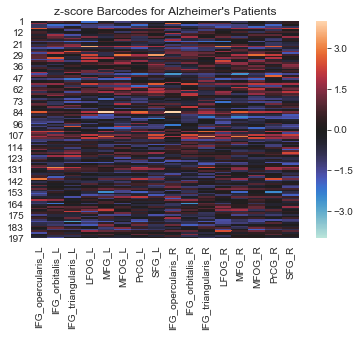

In [18]:
# heat map for all Alzheimer's patients
ax1 = sns.heatmap(ad_zscore, vmin=-4, vmax=4, center=0)
ax1.set(title = "z-score Barcodes for Alzheimer's Patients");

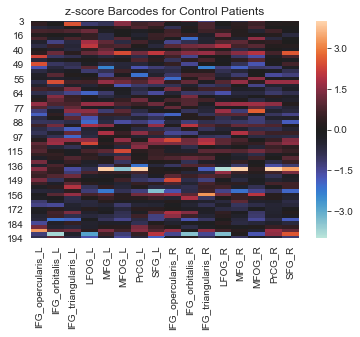

In [19]:
# heat map for all control patients
ax2 = sns.heatmap(control_zscore, vmin=-4, vmax=4, center=0)
ax2.set(title = "z-score Barcodes for Control Patients");

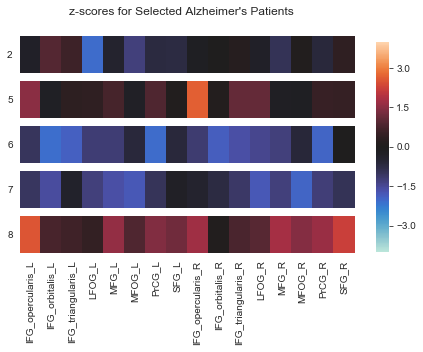

In [20]:
# selected heat maps
fig, axn = plt.subplots(5,1)
cbar_ax = fig.add_axes([0.95, 0.13, 0.03, .73])

plt.subplot(5,1,1)
sns.heatmap(ad_zscore.iloc[1:2], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,2)
sns.heatmap(ad_zscore.iloc[2:3], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,3)
sns.heatmap(ad_zscore.iloc[3:4], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,4)
sns.heatmap(ad_zscore.iloc[4:5], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,5)
sns.heatmap(ad_zscore.iloc[5:6], vmin=-4, vmax=4, center=0, cbar_ax=cbar_ax)
plt.yticks(rotation=0) 

fig.suptitle('z-scores for Selected Alzheimer\'s Patients');

### MRI Cloud Data
- z-score barcodes

In [21]:
# import z-score data calculated in MATLAB and rename
mri_zscore = pd.read_excel('MRICloud-data.xlsx').rename({0:'MRI Cloud AD', 1:'MRI Cloud Control'}, axis='index')

# split into AD and control groups
mri_zscore_ad = mri_zscore[mri_zscore.Group == 'ad_zscore'].drop(columns=['Group'])
mri_zscore_control = mri_zscore[mri_zscore.Group == 'control_zscore'].drop(columns=['Group'])

# drop 'Group' column
mri_zscore = mri_zscore.drop(columns=['Group'])
mri_zscore

,IFG_opercularis_L,IFG_orbitalis_L,IFG_triangularis_L,LFOG_L,MFG_L,MFOG_L,PrCG_L,SFG_L,IFG_opercularis_R,IFG_orbitalis_R,IFG_triangularis_R,LFOG_R,MFG_R,MFOG_R,PrCG_R,SFG_R
MRI Cloud AD,1.992300,-0.354717,-0.084717,-0.520302,8.305349,0.527966,1.123782,6.927068,1.187948,-0.301389,-0.174044,0.495051,9.967250,2.036756,-0.080966,12.904647
MRI Cloud Control,1.696835,-0.275199,0.003840,-0.395576,7.886959,0.957672,1.346317,8.471919,1.474773,-0.036666,0.050777,0.848882,7.951623,2.552342,-0.048376,12.428923


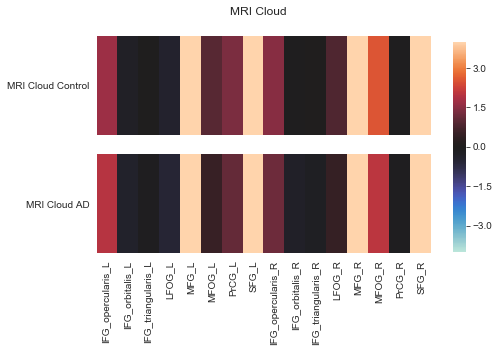

In [22]:
# MRI Cloud Control vs AD
fig, axn = plt.subplots(2,1)
cbar_ax = fig.add_axes([0.95, 0.13, 0.03, .73])

plt.subplot(2,1,1)
sns.heatmap(mri_zscore_control, xticklabels=False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(2,1,2)
sns.heatmap(mri_zscore_ad, vmin=-4, vmax=4, center=0, cbar_ax=cbar_ax)
plt.yticks(rotation=0)

fig.suptitle('MRI Cloud');

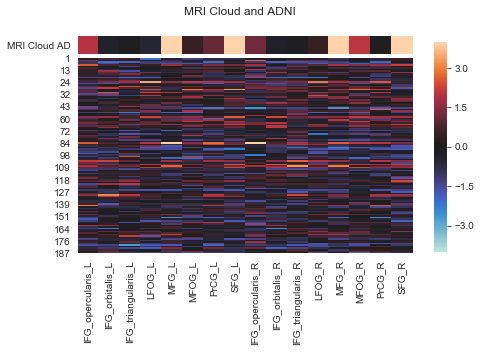

In [23]:
# AD vs MRI Cloud
fig, axn = plt.subplots(10,1)
cbar_ax = fig.add_axes([0.95, 0.13, 0.03, .73])

plt.subplot(10,1,1)
sns.heatmap(mri_zscore_ad, xticklabels=False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(10,1,(2,10))
sns.heatmap(ad_zscore, vmin=-4, vmax=4, center=0, cbar_ax=cbar_ax)
plt.yticks(rotation=0)

fig.suptitle('MRI Cloud and ADNI');

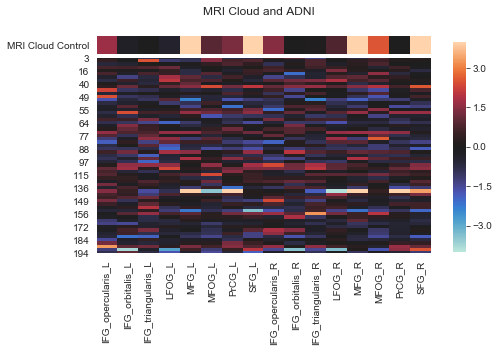

In [24]:
# Control vs MRI Cloud
fig, axn = plt.subplots(10,1)
cbar_ax = fig.add_axes([0.95, 0.13, 0.03, .73])

plt.subplot(10,1,1)
sns.heatmap(mri_zscore_control, xticklabels=False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(10,1,(2,10))
sns.heatmap(control_zscore, vmin=-4, vmax=4, center=0, cbar_ax=cbar_ax)
plt.yticks(rotation=0)

fig.suptitle('MRI Cloud and ADNI');

### Statistical Tests
- t-tests

In [25]:
# t-test for volumes from ADNI data (AD vs. Control)
(statistics, pvalues) = stats.ttest_ind(ad_volume, control_volume) 
#pvalues

Null Hypothesis: There is no difference in the mean volume for each region of the brain in the Frontal Lobe between the control group and the Alzheimer's group.

In [26]:
# add p-values to Dataframe with corresponding brain region and sort
df_pvals = pd.DataFrame({'p-values': pvalues}, index=rois)
df_pvals_sorted = df_pvals.sort_values(by=['p-values'])
rois_sorted = df_pvals_sorted.index # also sort lables
df_pvals_sorted

,p-values
LFOG_R,0.005055
PrCG_L,0.068467
IFG_orbitalis_R,0.073867
MFOG_L,0.098613
MFOG_R,0.124248
IFG_opercularis_R,0.133151
IFG_triangularis_R,0.139281
LFOG_L,0.206288
SFG_R,0.551783
IFG_triangularis_L,0.552317


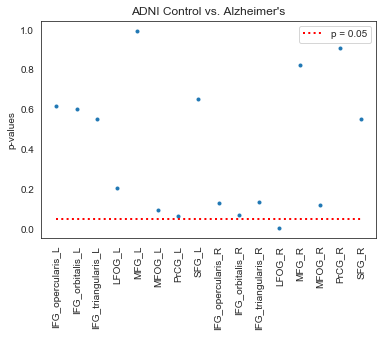

In [27]:
# plot p-values for each brain region
plt.plot(df_pvals['p-values'],'.', label='_nolegend_')
plt.plot(np.arange(df_pvals.shape[0]), np.full(df_pvals.shape[0],0.05), 'r:', linewidth=2)
plt.xticks(rotation='vertical')
plt.ylabel('p-values')
plt.legend(['p = 0.05'], loc='upper right')
plt.title('ADNI Control vs. Alzheimer\'s');

In [28]:
full_rois = ['left inferior frontal gyrus pars opercularis',
             'left inferior frontal gyrus pars orbitralis',
             'left inferior frontal gyrus pars triangularis',
             'left lateral fronto-orbital gyrus',
             'left middle frontal gyrus (posterior segment)',
             'left middle fronto-orbital gyrus',
             'left precentral gyrus',
             'left superior frontal gyrus (posterior segment)',
             'right inferior frontal gyrus pars opercularis',
             'right inferior frontal gyrus pars orbitralis',
             'right inferior frontal gyrus pars triangularis',
             'right lateral fronto-orbital gyrus',
             'right middle frontal gyrus (posterior segment)',
             'right middle fronto-orbital gyrus',
             'right precentral gyrus',
             'right superior frontal gyrus (posterior segment)']

In [29]:
# Print if result is or isn't significant
for i in range(len(pvalues)):
    if pvalues[i] < 0.05:
        print(f'There is a SIGNIFICANT difference between the average volume of the {full_rois[i]} ({rois[i]}) in the control group and Alzheimer\'s group in the ADNI dataset.\n')
    else:
        print(f'There is a NOT a significant difference between the average volume of the {full_rois[i]} ({rois[i]}) in the control group and Alzheimer\'s group in the ADNI dataset.\n')
        

There is a NOT a significant difference between the average volume of the left inferior frontal gyrus pars opercularis (IFG_opercularis_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT a significant difference between the average volume of the left inferior frontal gyrus pars orbitralis (IFG_orbitalis_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT a significant difference between the average volume of the left inferior frontal gyrus pars triangularis (IFG_triangularis_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT a significant difference between the average volume of the left lateral fronto-orbital gyrus (LFOG_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT a significant difference between the average volume of the left middle frontal gyrus (posterior segment) (MFG_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT